# Mean Square End-to-End Fluctuations

In [113]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from os import listdir
import pandas as pd

In [101]:
def CreateLpDataFrame(dirName):
    assert isinstance(dirName, str), "The 'dirName' argument must be a string!"
    fileNames = [dirName+'/'+i for i in listdir(dirName) if i[-6:] == '.mse2e']
    #df = pd.DataFrame(columns=['length','diameter','child_length','persistence_length','driving','ndim','nsteps','nspec','delta','theory'])
    df = pd.DataFrame(columns=['n_filaments','length','persistence_length','driving','ndim','theory','mse2e','std_err'])
    for filename in fileNames:
        f=open(filename)
        f.readline()
        f.readline()
        line = list(map(float,f.readline().split()))
        length,perlen,driving,ndim,theory = line[0],line[3],line[4],line[5],line[9]
        f.readline()
        line = f.readline().split()
        num,mse2e,stderr = int(line[0]),float(line[1]),float(line[2])
        f.close()
        temp_df = pd.DataFrame(data={'n_filaments':num,'length':length,'persistence_length':perlen,'driving':driving,'ndim':ndim,'theory':theory,'mse2e':mse2e,'std_err':stderr},index=[1])
        df = df.append(temp_df,ignore_index=True)
    return df

def GetRealUnits(df):
    df.loc[:,'length (nm)'] = df['length'].apply(lambda y: y*25.0)
    df.loc[:,'driving (pN/nm)'] = df['driving'].apply(lambda y: y*0.0064)
    df.loc[:,'persistence_length (nm)'] = df['persistence_length'].apply(lambda y: y*25.0)
    df.loc[:,'mse2e (nm^2)'] = df['mse2e'].apply(lambda y: y*25.0)
    df.loc[:,'std_err (nm^2)'] = df['std_err'].apply(lambda y: y*25.0)
    df.loc[:,'theory (nm^2)'] = df['theory'].apply(lambda y: y*25.0)
    df.loc[:,'effective_lp (nm)'] = df['effective_lp'].apply(lambda y: y*25.0)
    df.loc[:,'eff_lp_std_err (nm)'] = df['eff_lp_std_err'].apply(lambda y: y*25.0)


def BackCalc(row):
    lps = np.linspace(10,1000000,1000000)
    mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    ind=(abs(row['mse2e']-mse2e_func(row['length'],lps,row['ndim']))).argmin()
    return round(lps[ind])

def BackCalcErr(row):
    mse2e_deriv_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L + (2 if ndim==3 else 4)*L*np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp) - 2*Lp*(2 if ndim==3 else 8)*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
    return row['std_err']/mse2e_deriv_func(row['length'],row['effective_lp'],row['ndim'])
    #return abs(lps[ind+1]-lps[ind-1])/abs(mse2e_func(row['length'],lps[ind+1],row['ndim'])-mse2e_func(row['length'],lps[ind-1],row['ndim']))

def BackCalculateLp(df,range_min=50,range_max=50000):
    df.loc[:,'effective_lp'] = df.apply(BackCalc, axis=1)
    df.loc[:,'eff_lp_std_err'] = df.apply(BackCalcErr, axis=1)


### Next cell is raw text, convert back to code to rerun

In [102]:
df = CreateLpDataFrame('mse2e_analysis/')
BackCalculateLp(df)
GetRealUnits(df)
df.to_pickle('mse2e_data_new.pkl')

In [103]:
df = pd.read_pickle('mse2e_data_new.pkl')

In [104]:
df.head()

,driving,length,mse2e,n_filaments,ndim,persistence_length,std_err,theory,effective_lp,eff_lp_std_err,length (nm),driving (pN/nm),persistence_length (nm),mse2e (nm^2),std_err (nm^2),theory (nm^2),effective_lp (nm),eff_lp_std_err (nm)
0,0.0,50.0,2494.92,100,2.0,4000.0,0.465292,2494.8,4095.0,375.664293,1250.0,0.000,100000.0,62373.00,11.632300,62370.0,102375.0,9391.607318
1,0.0,50.0,2497.51,100,2.0,8000.0,0.225387,2497.4,8361.0,757.418215,1250.0,0.000,200000.0,62437.75,5.634675,62435.0,209025.0,18935.455374
2,0.0,50.0,2498.75,100,2.0,16000.0,0.114309,2498.7,16661.0,1524.226695,1250.0,0.000,400000.0,62468.75,2.857725,62467.5,416525.0,38105.667378
3,5.0,50.0,2494.89,100,2.0,4000.0,0.458095,2494.8,4071.0,365.537625,1250.0,0.032,100000.0,62372.25,11.452375,62370.0,101775.0,9138.440614
4,5.0,50.0,2497.48,100,2.0,8000.0,0.227010,2497.4,8261.0,744.746570,1250.0,0.032,200000.0,62437.00,5.675250,62435.0,206525.0,18618.664248


<IPython.core.display.Javascript object>


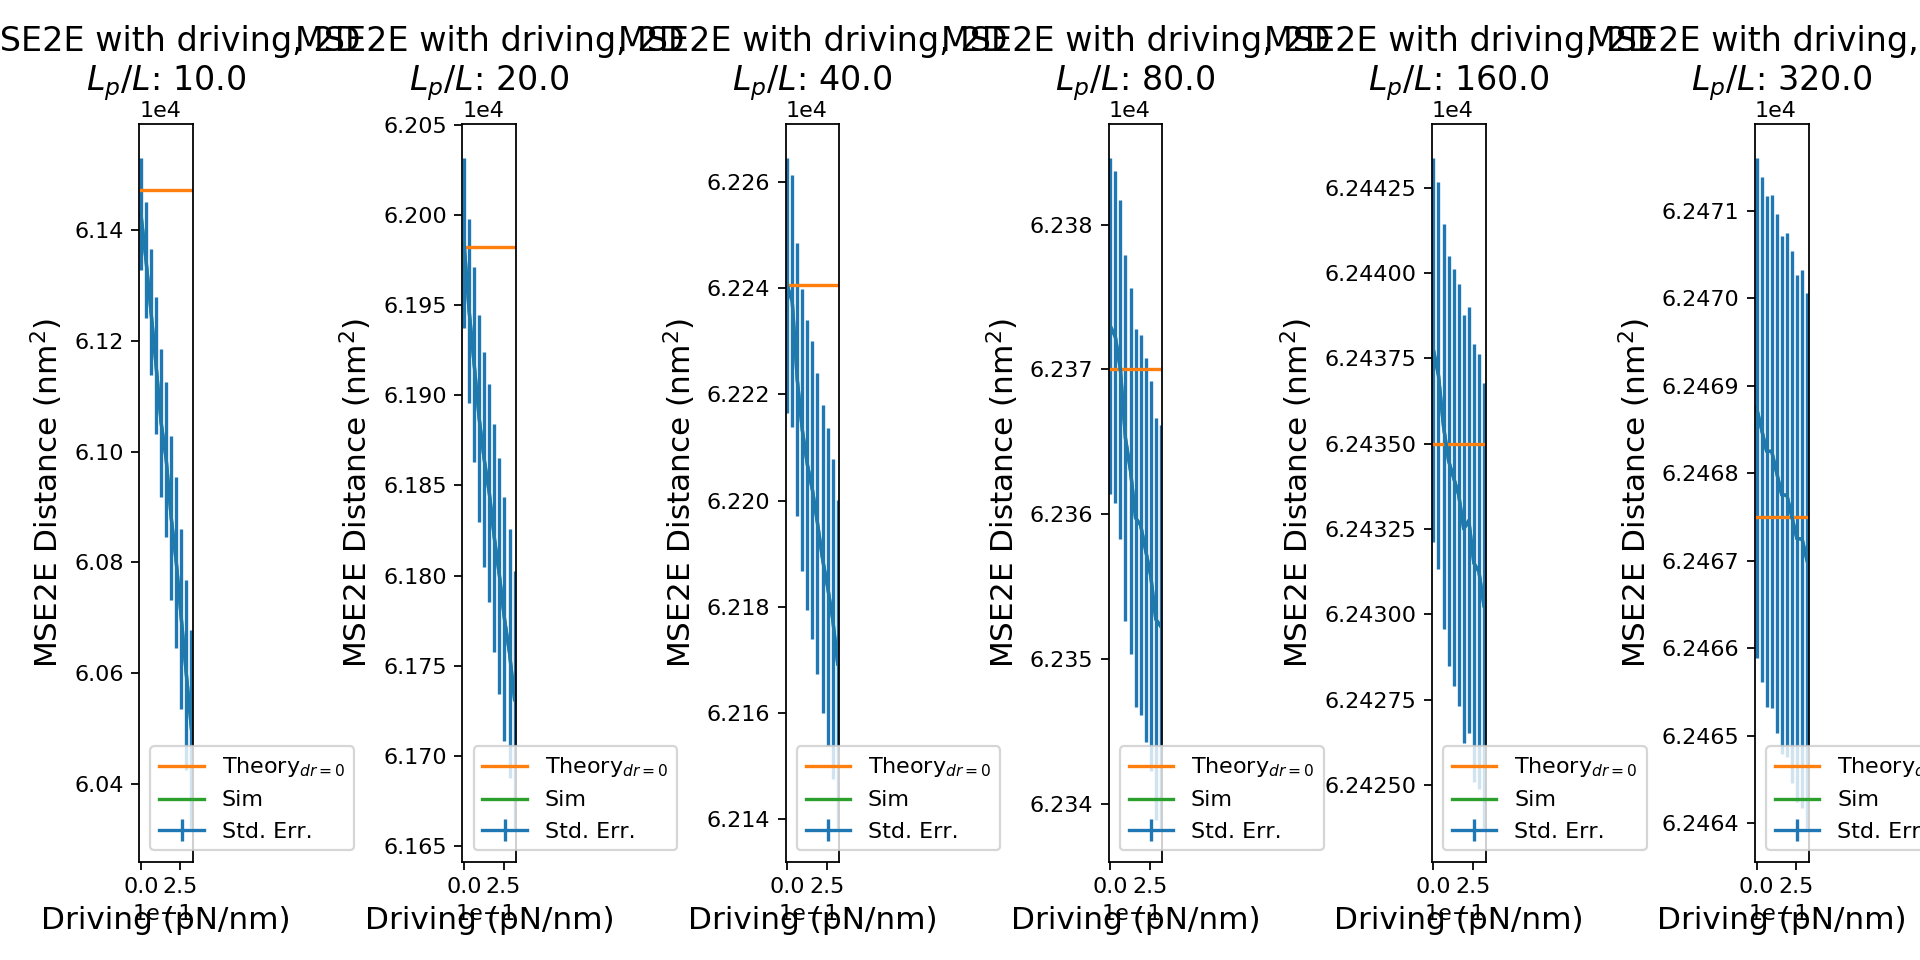

In [105]:
df2d = df[df['ndim']==2]
df3d = df[df['ndim']==3]
grouped=df2d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 2D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend([r'Theory$_{dr=0}$','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

<IPython.core.display.Javascript object>


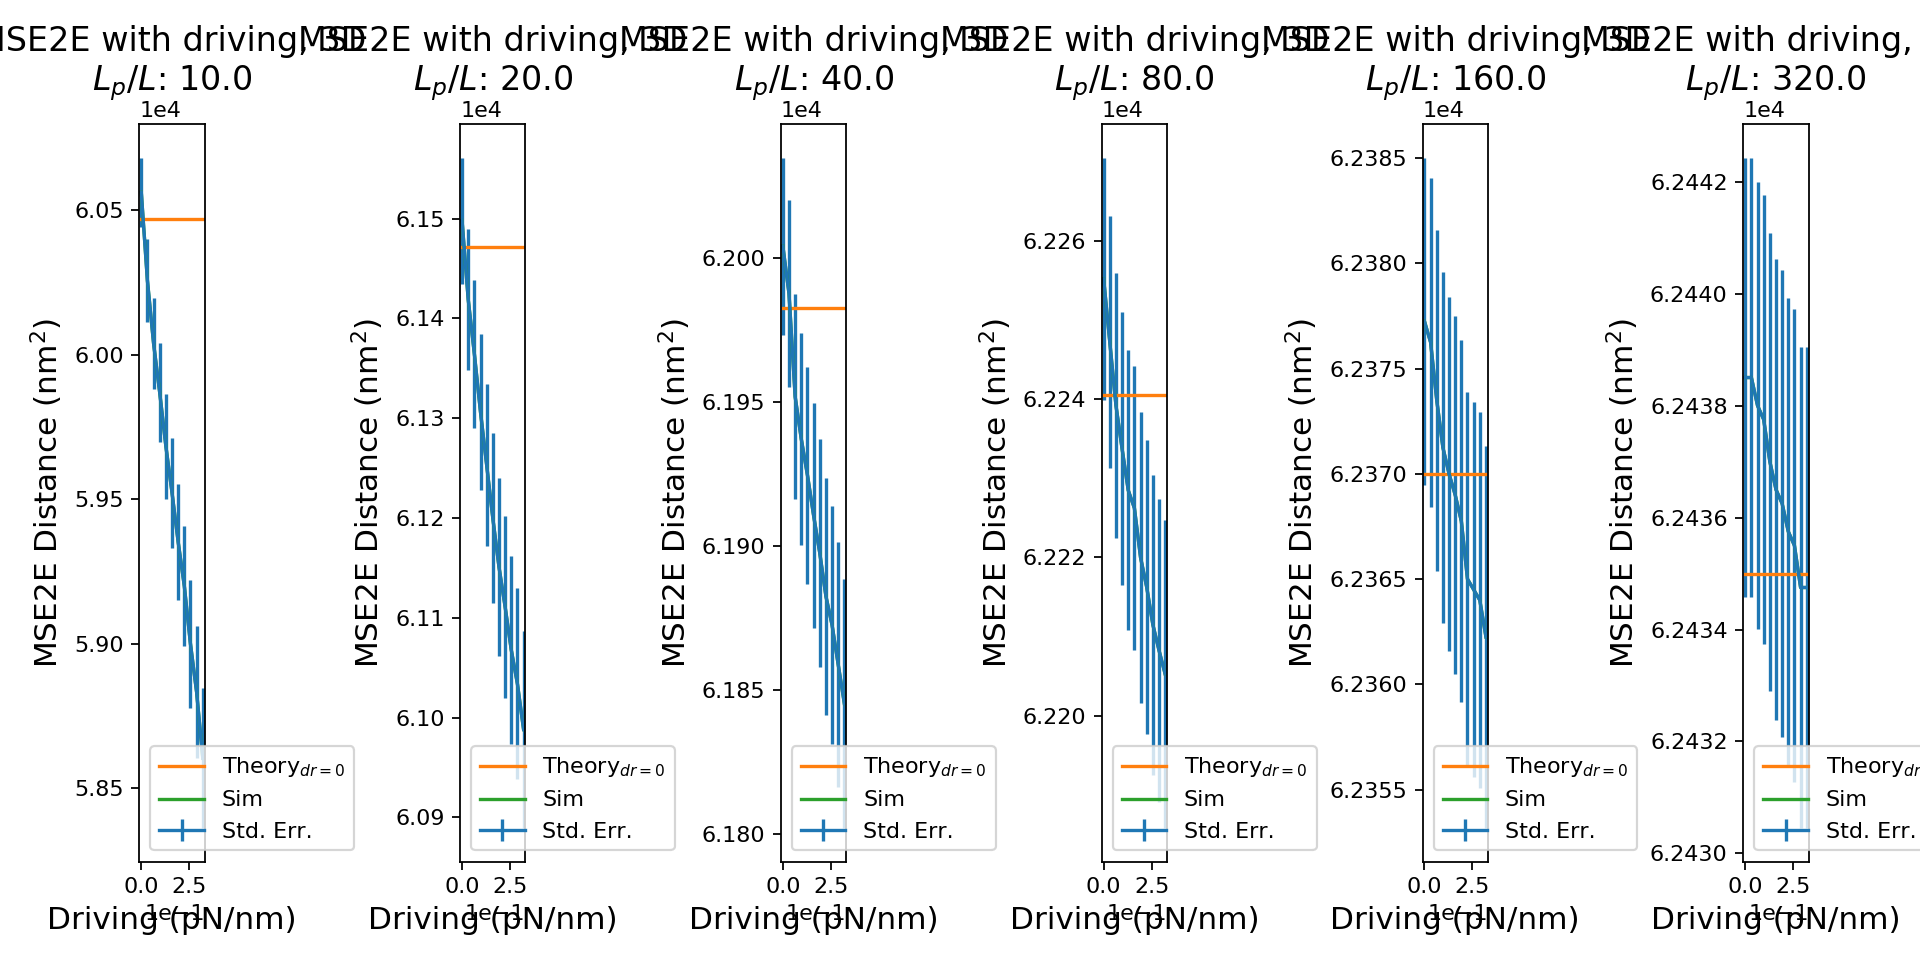

In [106]:
grouped=df3d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 3D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['mse2e (nm^2)'],yerr=group['std_err (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['theory (nm^2)'])
    ax[i].plot(group['driving (pN/nm)'],group['mse2e (nm^2)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'MSE2E Distance (nm$^2$)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend([r'Theory$_{dr=0}$','Sim','Std. Err.'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#(rect=(0.05,0.1,0.95,0.9),pad=-1.5)
plt.show()

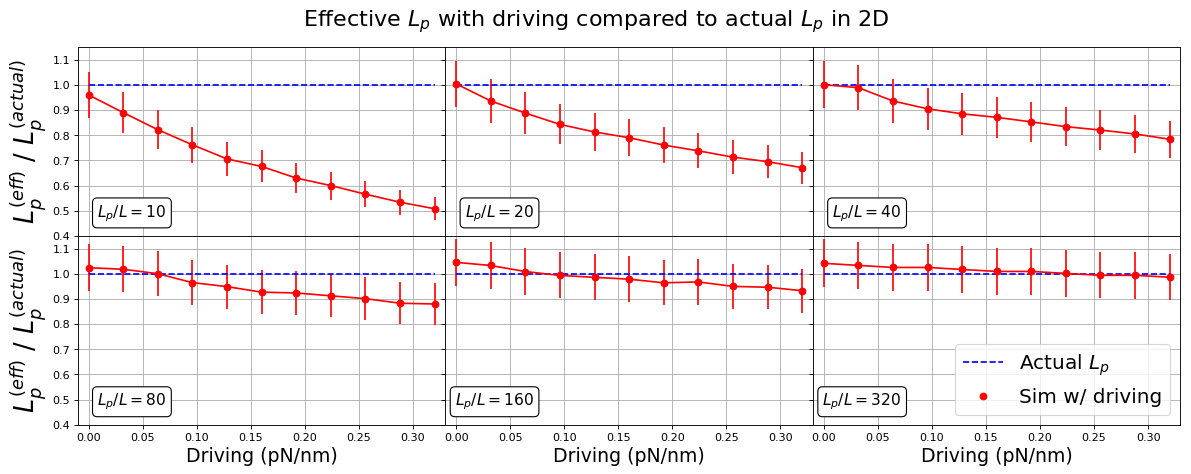

In [166]:
grouped=df2d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=2,ncols=int(len(grouped)/2),figsize=(15,6),dpi=80,sharey=True,sharex=True)
i=0
j=0
ax[0][0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
ax[1][0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
fig.suptitle("Effective " + r'$L_p$' +" with driving compared to actual " r'$L_p$' +" in 2D",fontsize=20)
for perlen,group in grouped:
    #ax[i].set_title("\n\n"+r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.0)
    ax[i][j].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=group['eff_lp_std_err (nm)']/group['persistence_length (nm)'],color='red')
    ax[i][j].plot(group['driving (pN/nm)'],group['persistence_length (nm)']/group['persistence_length (nm)'],'b--')
    ax[i][j].plot(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],'ro')
    #ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    #ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    #ax[i].set_ylabel(r'Effective $L_p$ / Actual $L_p$',fontsize=14)
    if i>0:
        ax[i][j].set_xlabel("Driving (pN/nm)",fontsize=17)
    #ax[i][j].legend(markerscale=0)
    #ax[i][j].legend([r'$L_{p}/L = %.0f$'%(perlen/(50*25))],loc=3,fontsize=14)
    ax[i][j].annotate(r'$L_{p}/L = %.0f$'%(perlen/(50*25)), xy=(80, 30), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    ax[i][j].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    ax[i][j].grid(True)
    ax[i][j].set_ylim(0.4,1.15)
    textstr = '$L_p/L=%.0f$'%(perlen/(50*25))
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    #ax[i].text(0.2, 0.1, textstr, transform=ax[i].transAxes, fontsize=20,
    #        verticalalignment='top', bbox=props)
    j+=1
    if j>2:
        i+=1
        j=0


ax[1][2].legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=18,loc=4)
#fig.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=20)

fig.tight_layout(rect=(0,0,1,0.93))
fig.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout(rect=(0.05,0.1,0.95,0.9),pad=0)
plt.savefig('mse2e_2d.png')
#plt.show()

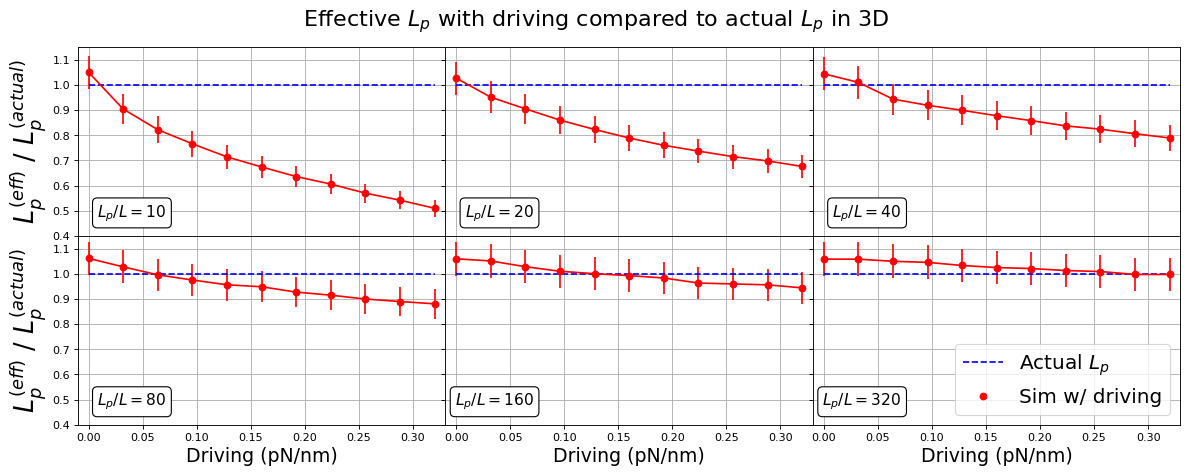

In [165]:
grouped=df3d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=2,ncols=int(len(grouped)/2),figsize=(15,6),dpi=80,sharey=True,sharex=True)
i=0
j=0
ax[0][0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
ax[1][0].set_ylabel(r'$L_{p}^{(eff)}$ / $L^{(actual)}_{p}$',fontsize=23)
fig.suptitle("Effective " + r'$L_p$' +" with driving compared to actual " r'$L_p$' +" in 3D",fontsize=20)
for perlen,group in grouped:
    #ax[i].set_title("\n\n"+r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.0)
    ax[i][j].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=group['eff_lp_std_err (nm)']/group['persistence_length (nm)'],color='red')
    ax[i][j].plot(group['driving (pN/nm)'],group['persistence_length (nm)']/group['persistence_length (nm)'],'b--')
    ax[i][j].plot(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],'ro')
    #ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    #ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    #ax[i].set_ylabel(r'Effective $L_p$ / Actual $L_p$',fontsize=14)
    if i>0:
        ax[i][j].set_xlabel("Driving (pN/nm)",fontsize=17)
    #ax[i][j].legend(markerscale=0)
    #ax[i][j].legend([r'$L_{p}/L = %.0f$'%(perlen/(50*25))],loc=3,fontsize=14)
    ax[i][j].annotate(r'$L_{p}/L = %.0f$'%(perlen/(50*25)), xy=(80, 30), xycoords='axes points',
            size=14, ha='right', va='top',
            bbox=dict(boxstyle='round', fc='w'))
    ax[i][j].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    ax[i][j].grid(True)
    ax[i][j].set_ylim(0.4,1.15)
    textstr = '$L_p/L=%.0f$'%(perlen/(50*25))
    props = dict(boxstyle='square', facecolor='white', alpha=1)
    #ax[i].text(0.2, 0.1, textstr, transform=ax[i].transAxes, fontsize=20,
    #        verticalalignment='top', bbox=props)
    j+=1
    if j>2:
        i+=1
        j=0


ax[1][2].legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=18,loc=4)
#fig.legend([r'Actual $L_{p}$','Sim w/ driving'],fontsize=20)

fig.tight_layout(rect=(0,0,1,0.93))
fig.subplots_adjust(wspace=0.0,hspace=0.0)
#fig.tight_layout(rect=(0.05,0.1,0.95,0.9),pad=0)
plt.savefig('mse2e_3d.png')
#plt.show()

<IPython.core.display.Javascript object>


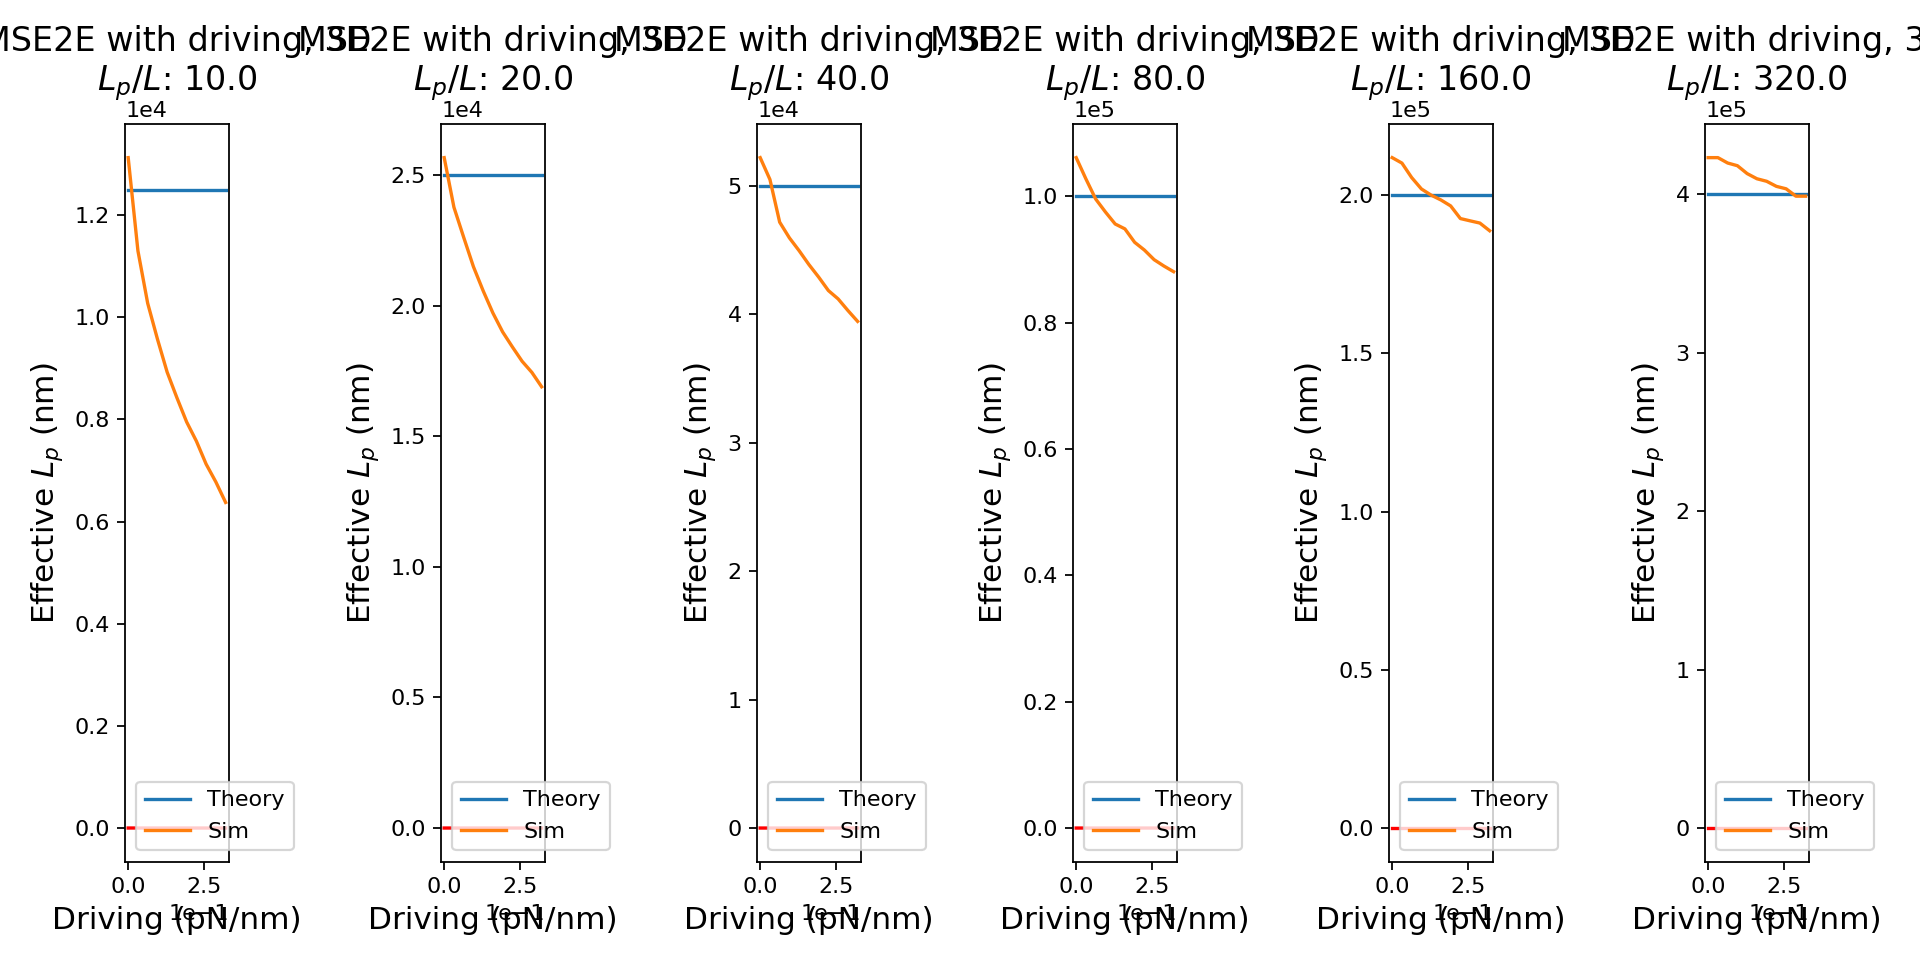

In [93]:
grouped=df3d.groupby('persistence_length (nm)')
fig,ax=plt.subplots(nrows=1,ncols=len(grouped),figsize=(12,6),dpi=80)
i=0
for perlen,group in grouped:
    ax[i].set_title("MSE2E with driving, 3D\n" + r'$L_p/L$: ' + str(perlen/(50*25)),fontsize=15,y=1.02)
    ax[i].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)']/group['persistence_length (nm)'],yerr=group['eff_lp_std_err (nm)']/group['persistence_length (nm)'],color='red')
#    ax[i].errorbar(group['driving (pN/nm)'],group['effective_lp (nm)'],yerr=(group['eff_lp_lower (nm)'],group['eff_lp_upper (nm)']))
    ax[i].plot(group['driving (pN/nm)'],group['persistence_length (nm)'])
    ax[i].plot(group['driving (pN/nm)'],group['effective_lp (nm)'])
    ax[i].ticklabel_format(sytle='sci',axis='x',scilimits=(0,0))
    ax[i].ticklabel_format(sytle='sci',axis='y',scilimits=(0,0))
    ax[i].set_ylabel(r'Effective $L_p$ (nm)',fontsize=14)
    ax[i].set_xlabel("Driving (pN/nm)",fontsize=14)
    ax[i].legend(['Theory','Sim'],loc=3)
    ax[i].set_xlim(min(group['driving (pN/nm)'])-0.01,max(group['driving (pN/nm)'])+0.01)
    i+=1
fig.tight_layout()#rect=(0.05,0.1,0.95,0.9),pad=0)
plt.show()

In [74]:
mse2e_func = lambda L,Lp,ndim: (2 if ndim==3 else 4)*L*Lp - (2 if ndim==3 else 8)*Lp*Lp*(1-np.exp(-(1 if ndim==3 else 0.5)*float(L)/Lp))
mse2e_func(50,5000,3)

2491.6874584053294